In [1]:
library(dyno)
library(scran)
library(scater)
library(slurmR)
library(dyngen)
library(igraph)
library(parallel)
library(dynutils)
library(tidyverse)
library(assertthat)
library(data.table)
library(SingleCellExperiment)
source("../scripts/perturbation.R")
source("../scripts/backbone_cellpop.R")

set.seed(1)
options(repr.plot.width=12, repr.plot.height=12)

Loading required package: dynfeature

Loading required package: dynguidelines

Loading required package: dynmethods

Loading required package: dynplot

Loading required package: dynwrap

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowColla

# Testing My KO Scripts on Dyngen KO Tutorial Data

In [2]:
backbone = backbone_bifurcating()

config = initialise_model(
            backbone = backbone,
            num_cells = 1000,
            num_tfs = nrow(backbone$module_info),
            num_targets = 250,
            num_hks = 250,
            simulation_params = simulation_default(
              census_interval = 10, 
              ssa_algorithm = ssa_etl(tau = 300 / 3600),
              experiment_params = simulation_type_wild_type(num_simulations = 100)
            )
          )

In [3]:
model_common = config %>%
                  generate_tf_network() %>%
                  generate_feature_network() %>% 
                  generate_kinetics() %>%
                  generate_gold_standard()

Generating TF network
Sampling feature network from real network
Generating kinetics for 535 features
Generating formulae
Generating gold standard mod changes
Precompiling reactions for gold standard
Running gold simulations
  |==================================================| 100% elapsed=02s, remaining~00s


In [17]:
b3_genes = model_common$feature_info %>% filter(module_id == "B3") %>% pull(feature_id)
perturb_expr = run_perturbation_experiment(model_common, b3_genes, cluster=TRUE)
sce = as_sce(perturb_expr)

Warning message:
“The path /mnt/scratcha/fmlab/baker02/tidyscreen/notebooks/slurmr-job-88f21325bc63 already exists. To overwrite a previously used path (tmp_path/job_name) use the option `overwrite = TRUE`”
Submitting job...
 jobid:13723731.



Merging model 1/2 CTRL
Merging model 2/2 B3_TF1_grna_1
Recomputing dimred
Simulating experiment


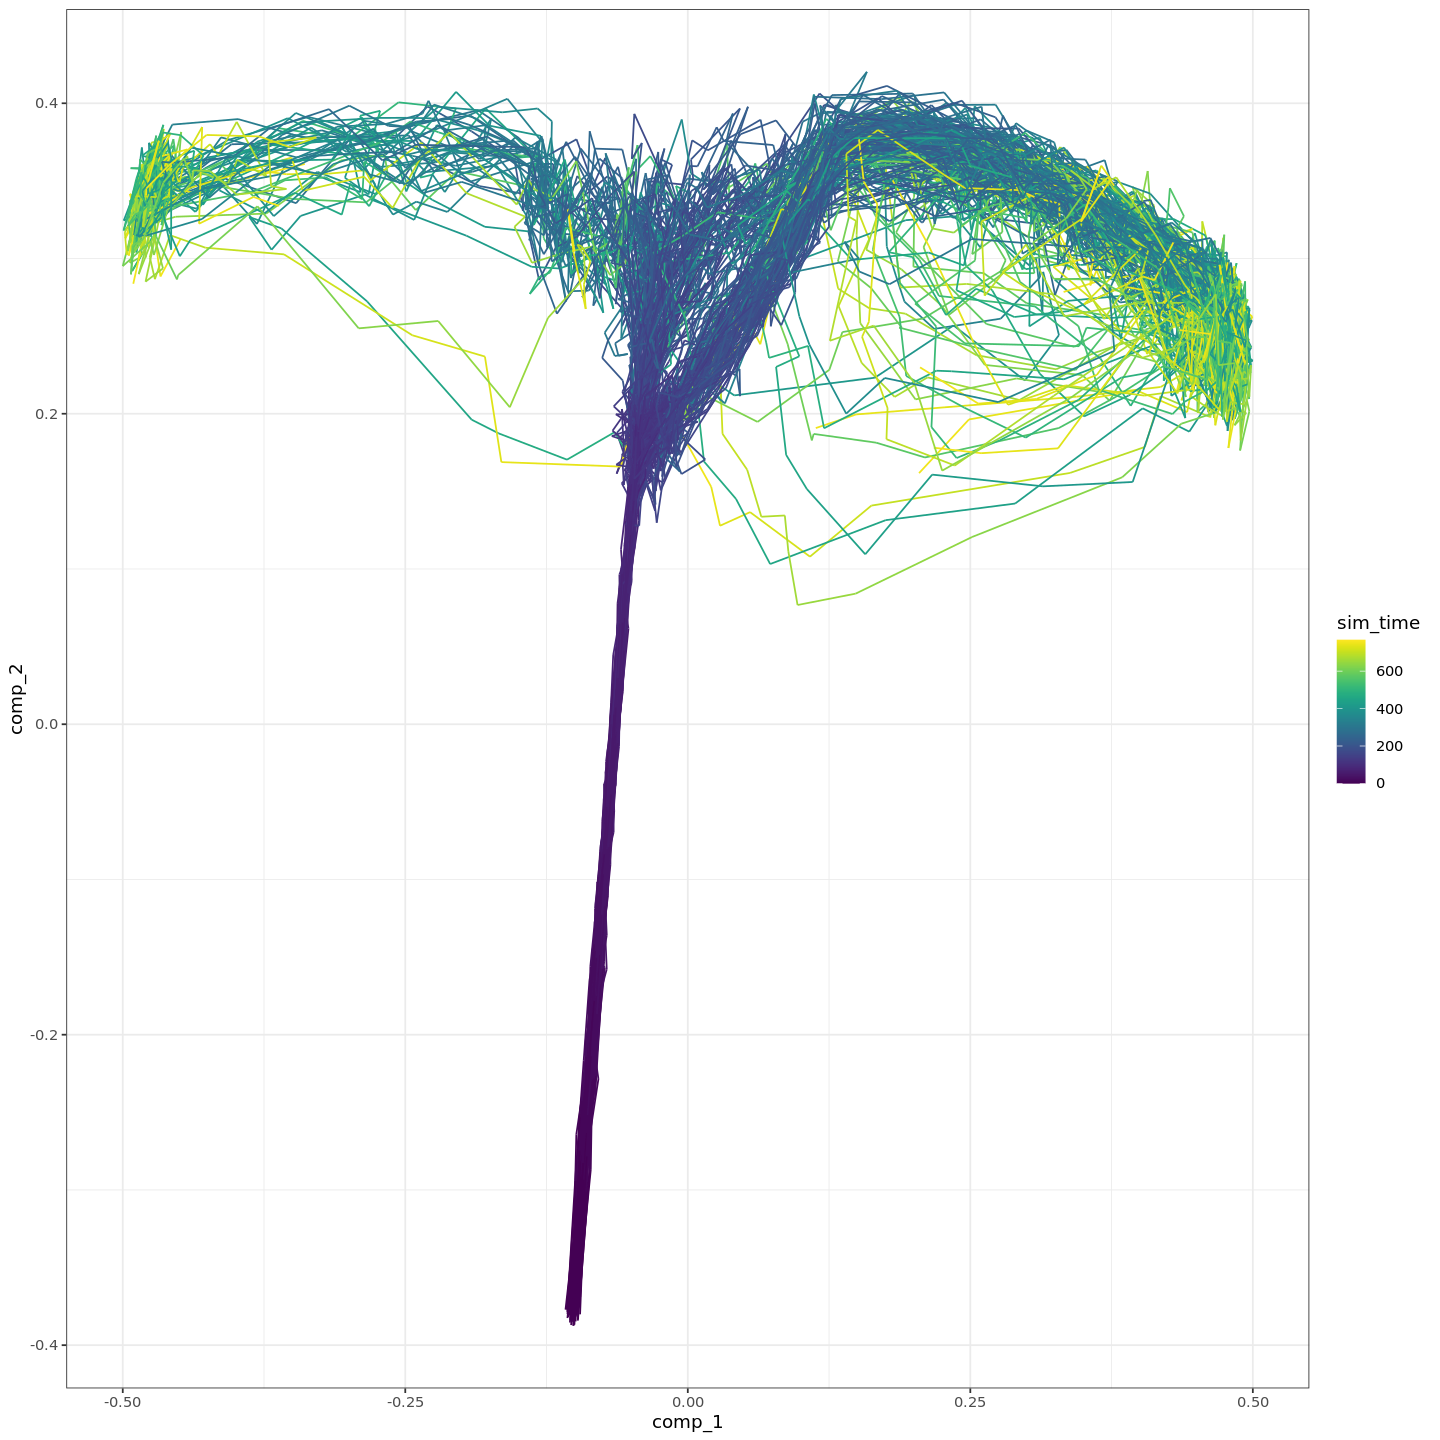

In [18]:
plot_simulations(perturb_expr)

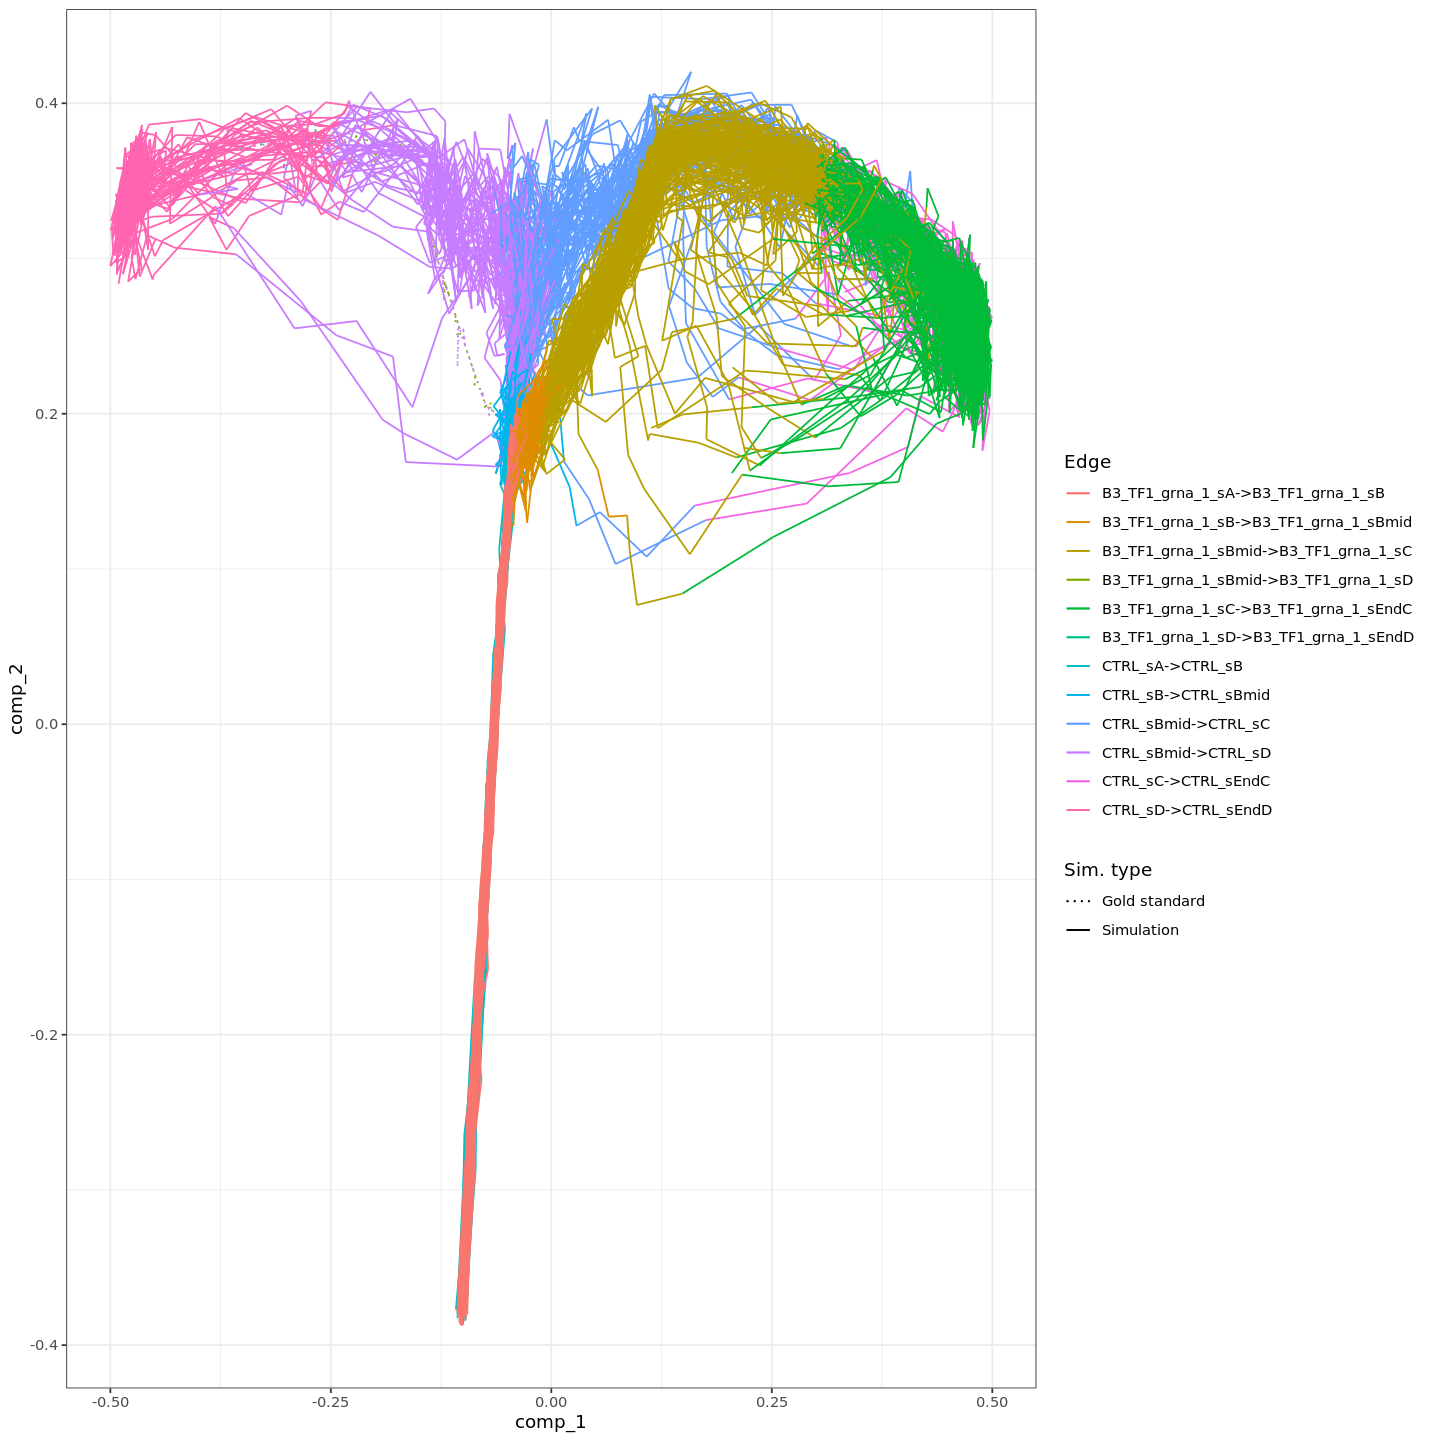

In [19]:
plot_gold_mappings(perturb_expr, do_facet = FALSE)

In [20]:
clust.sce = quickCluster(sce) 
sce = computeSumFactors(sce, cluster=clust.sce)
sce = logNormCounts(sce)

dec = modelGeneVar(sce)
chosen = getTopHVGs(dec, prop=0.1)

sce = runPCA(sce, subset_row=chosen) 
sce = runUMAP(sce, dimred="PCA")

Warning message in check_numbers(k = k, nu = nu, nv = nv, limit = min(dim(x)) - :
“more singular values/vectors requested than available”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invalid!; try increasing work or maxit”


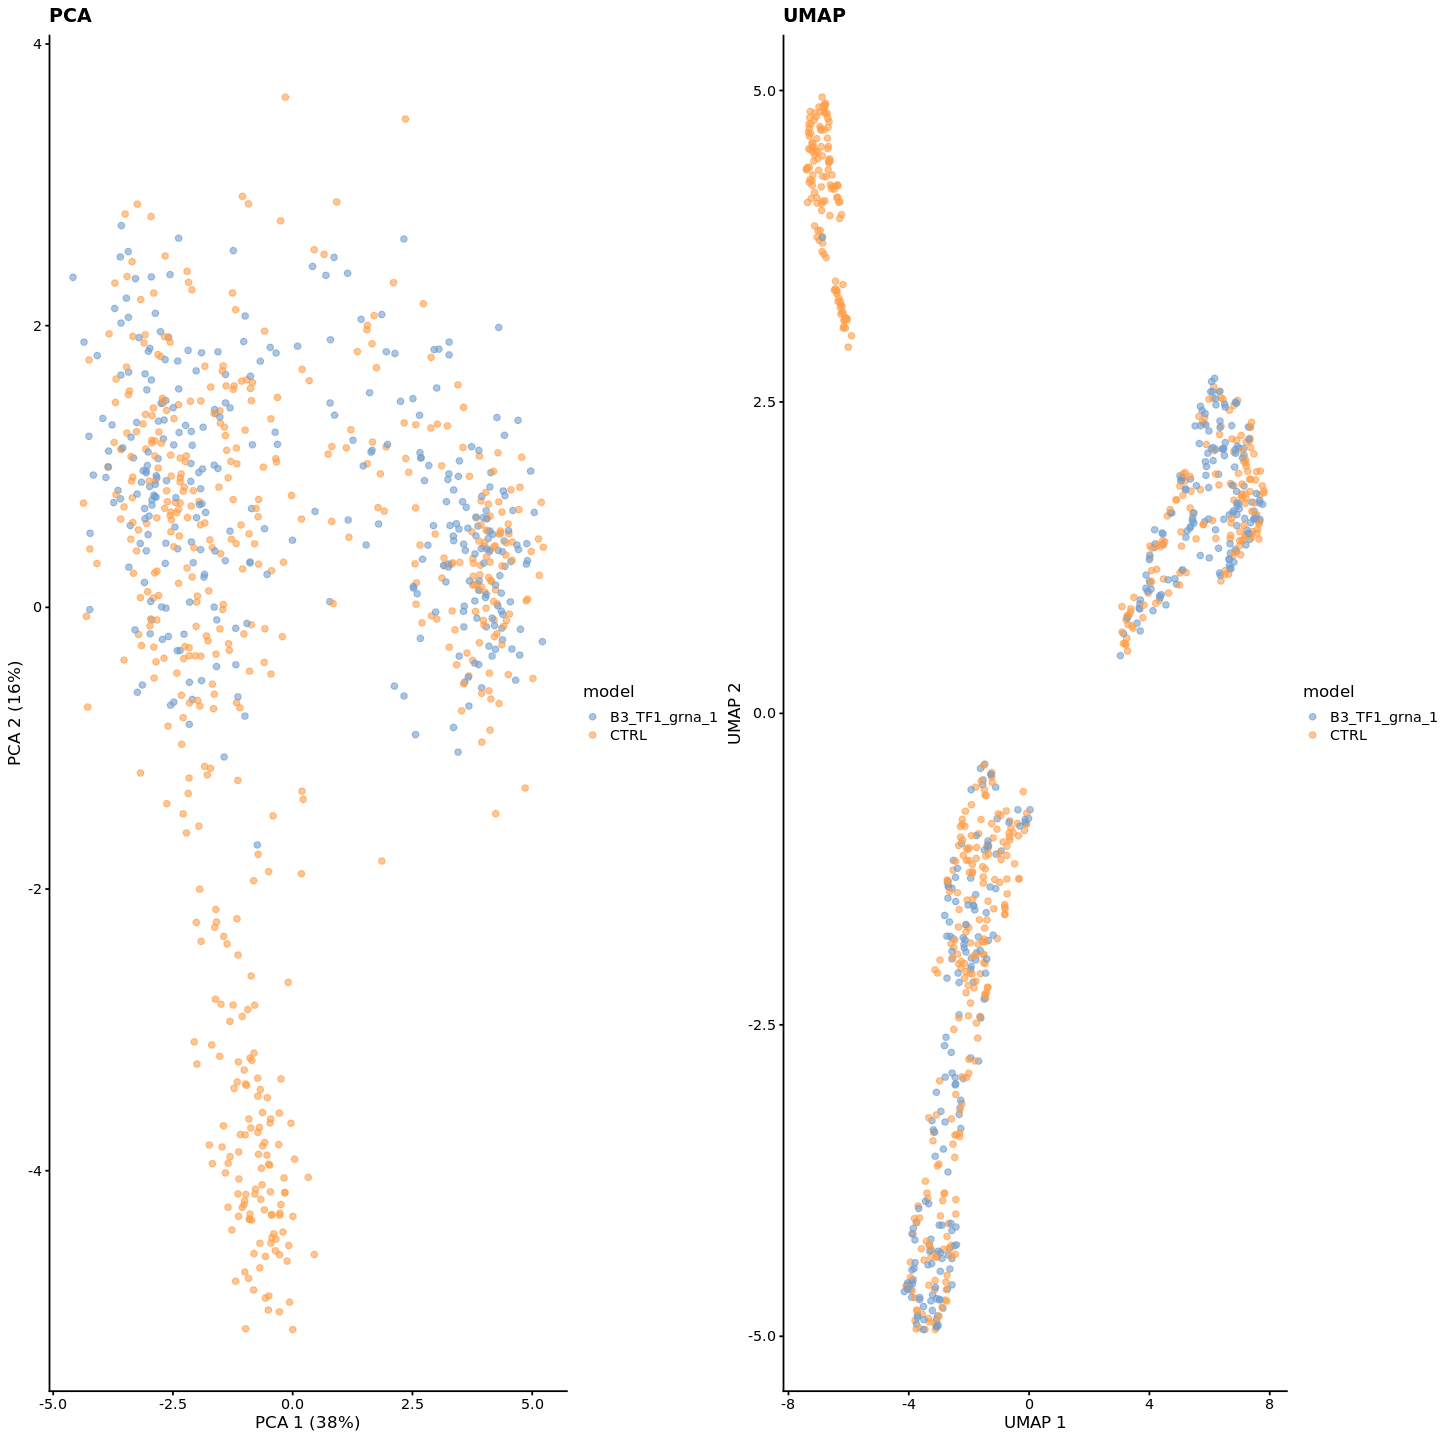

In [21]:
gridExtra::grid.arrange(
    plotPCA(sce, colour_by='model') + ggtitle("PCA"),
    plotUMAP(sce, colour_by='model') + ggtitle("UMAP"),
    ncol=2
)

# Convert Counts Model to PBMC

In [22]:
data("realcounts", package = "dyngen")
name_realcounts <- "zenodo_1443566_real_silver_bone-marrow-mesenchyme-erythrocyte-differentiation_mca"
url_realcounts <- realcounts %>% filter(name == name_realcounts) %>% pull(url)
realcount <- dyngen:::.download_cacheable_file(url_realcounts, getOption("dyngen_download_cache_dir"), verbose = FALSE)